  # American Express - Default Prediction (Transformer)

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w207 - Applied Machine Learning Final Project

Team: Zhuo Chen, Julian Rippert, Jim Zhu

Year: 2023

Semester: Spring

Section: 004

## Kaggle Competition

[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview/description)

### Motivation

Whether dining at a restaurant or purchasing concert tickets, the convenience of a credit card is crucial for everyday transactions. Credit cards eliminate the need to carry large sums of cash and allow us to make purchases that can be paid off over time. But how do card issuers ensure we'll repay our charges? This is a complex issue with numerous existing solutions, and even more potential enhancements, which this competition aims to explore.

Predicting credit default is a vital aspect of managing risk in consumer lending businesses. It enables lenders to refine their lending decisions, leading to improved customer experiences and robust business economics. While current models help mitigate risk, there is room for developing superior models that outperform existing ones.

American Express, a leading global payments company and the world's largest payment card issuer, provides customers with access to products, insights, and experiences that enhance their lives and foster business growth.

Why does this matter? Default events are financially detrimental to banks and card issuers, as they are unable to recover the funds lent to consumers through credit. Banks can utilize default prediction models to monitor their existing cardholder base and proactively collaborate with consumers to avert default situations. Additionally, banks may employ such models to determine whether to extend credit to potential new customers.

### Dataset Description

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

with the following features being categorical:
<blockquote>
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
</blockquote>

The task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

### Evaluation

The evaluation metric for this competition combines two different measures of rank ordering: the Normalized Gini Coefficient (NGC) and the default rate captured at 4% (DRC_4%). The final evaluation metric is the mean of these two sub-metrics.

Normalized Gini Coefficient (NGC):
The Gini Coefficient is a measure of inequality, often used in economics to measure income inequality. In the context of classification problems, the Gini Coefficient can be used to evaluate the performance of a model by measuring the degree of inequality between the predicted probabilities and the true labels. The Normalized Gini Coefficient is the Gini Coefficient divided by the maximum possible Gini Coefficient, resulting in a value between 0 and 1. A higher NGC indicates better model performance.

Default Rate Captured at 4% (DRC_4%):
This metric represents the proportion of true positive labels (defaults) captured within the top 4% of the highest-ranked predictions made by the model. It reflects the model's sensitivity or recall in identifying the positive class (defaults) when only considering the top 4% of predicted probabilities. A higher DRC_4% indicates better model performance.

Weighted Labels:
Due to downsampling, negative labels are given a weight of 20 in the calculation of both NGC and DRC_4%. This helps to balance the evaluation metric, as there are fewer negative examples in the dataset.

Final Evaluation Metric:
The final evaluation metric is the mean of NGC and DRC_4%, resulting in a value between 0 and 1. A higher value indicates better model performance. The goal of the competition is to maximize this metric.

### Competition Metric

The competition metric is defined from [Amex Competition Metric](https://www.kaggle.com/code/inversion/amex-competition-metric-python)

In [29]:
def amex_metric_mod(y_true, y_pred):
  labels     = np.transpose(np.array([y_true, y_pred]))
  labels     = labels[labels[:, 1].argsort()[::-1]]
  weights    = np.where(labels[:,0]==0, 20, 1)
  cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
  top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

  gini = [0,0]
  for i in [1,0]:
    labels         = np.transpose(np.array([y_true, y_pred]))
    labels         = labels[labels[:, i].argsort()[::-1]]
    weight         = np.where(labels[:,0]==0, 20, 1)
    weight_random  = np.cumsum(weight / np.sum(weight))
    total_pos      = np.sum(labels[:, 0] *  weight)
    cum_pos_found  = np.cumsum(labels[:, 0] * weight)
    lorentz        = cum_pos_found / total_pos
    gini[i]        = np.sum((lorentz - weight_random) * weight)

  return 0.5 * (gini[1]/gini[0] + top_four)

## General Process

### Install Libraries

In [4]:
!pip install cupy-cuda11x

### Load Libraries

In [8]:
import warnings
warnings.filterwarnings("ignore")

import cupy # GPU LIBRARIES
import numpy as np, pandas as pd # CPU LIBRARIES
import matplotlib.pyplot as plt, gc, os

os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"  # TF will not use all memory
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print('Using TensorFlow version',tf.__version__)

Using TensorFlow version 2.11.0


## Process Train Data

In [9]:
PATH_TO_DATA = '/mnt/c/Users/chenz/Documents/WSL2/amex-default/data/'
PATH_TO_MODEL = '/mnt/c/Users/chenz/Documents/WSL2/amex-default/model/'
PATH_TO_SUBMISSIONS = '/mnt/c/Users/chenz/Documents/WSL2/amex-default/submissions/'

PROCESS_DATA = True
TRAIN_MODEL = True
INFER_TEST = True

### Load Data

Read the data from @munumbutt's [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather?select=train_data_f32.ftr) In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit

In [10]:
if PROCESS_DATA:
  train_df = pd.read_feather(f'{PATH_TO_DATA}train_data.ftr')
  targets = train_df[['customer_ID', 'target']]
  targets['customer_ID'] = targets['customer_ID'].apply(lambda x: int(x[-16:],16)).astype('int64')
  targets = targets.drop_duplicates().sort_index()
  print(f'There are {targets.shape[0]} train targets')
  T_COLS = train_df.columns
  print(f'There are {len(T_COLS)} train dataframe columns')
  train_ids = train_df['customer_ID'].apply(lambda x: int(x[-16:],16)).astype('int64')
  customers = train_ids.drop_duplicates().sort_index().values.flatten()
  print(f'There are {len(customers)} unique customers in train.')
  
  display(train_df.head(2))

There are 458913 train targets
There are 191 train dataframe columns
There are 458913 unique customers in train.


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


We process both train and test data in chunks. We split train data into 10 parts and process each part separately and save to disk. We split test into 20 parts. This allows us to avoid memory errors during processing.

In [11]:
# calculate size of each separate file
def get_rows(customers, train_ids, NUM_FILES = 10, verbose = ''):
  chunk = len(customers)//NUM_FILES
  if verbose != '':
    print(f'We will split {verbose} data into {NUM_FILES} separate files.')
    print(f'There will be {chunk} customers in each file (except the last file).')
    print('Below are number of rows in each file:')
  rows = []

  for k in range(NUM_FILES):
    if k==NUM_FILES-1: cc = customers[k*chunk:]
    else: cc = customers[k*chunk:(k+1)*chunk]
    s = train_ids.loc[train_ids.isin(cc)].shape[0]
    rows.append(s)
  if verbose != '': print( rows )
  return rows

In [12]:
# split training data into 10 files
NUM_FILES = 10
if PROCESS_DATA:
  rows = get_rows(customers, train_ids, NUM_FILES = NUM_FILES, verbose = 'train')

We will split train data into 10 separate files.
There will be 45891 customers in each file (except the last file).
Below are number of rows in each file:
[553403, 552855, 554025, 554330, 552004, 552378, 552822, 553151, 553493, 552990]


### Pre-Processing & Feature Engineering

In this competition, data regarding credit card customers is provided in a 2D format. However, we cannot directly use these files for training Transformers without adjustments, as each customer possesses a varying number of credit card statements.

To input time series data into a Transformer, it is essential to ensure that all customers have the same sequence length (13 in this competition).

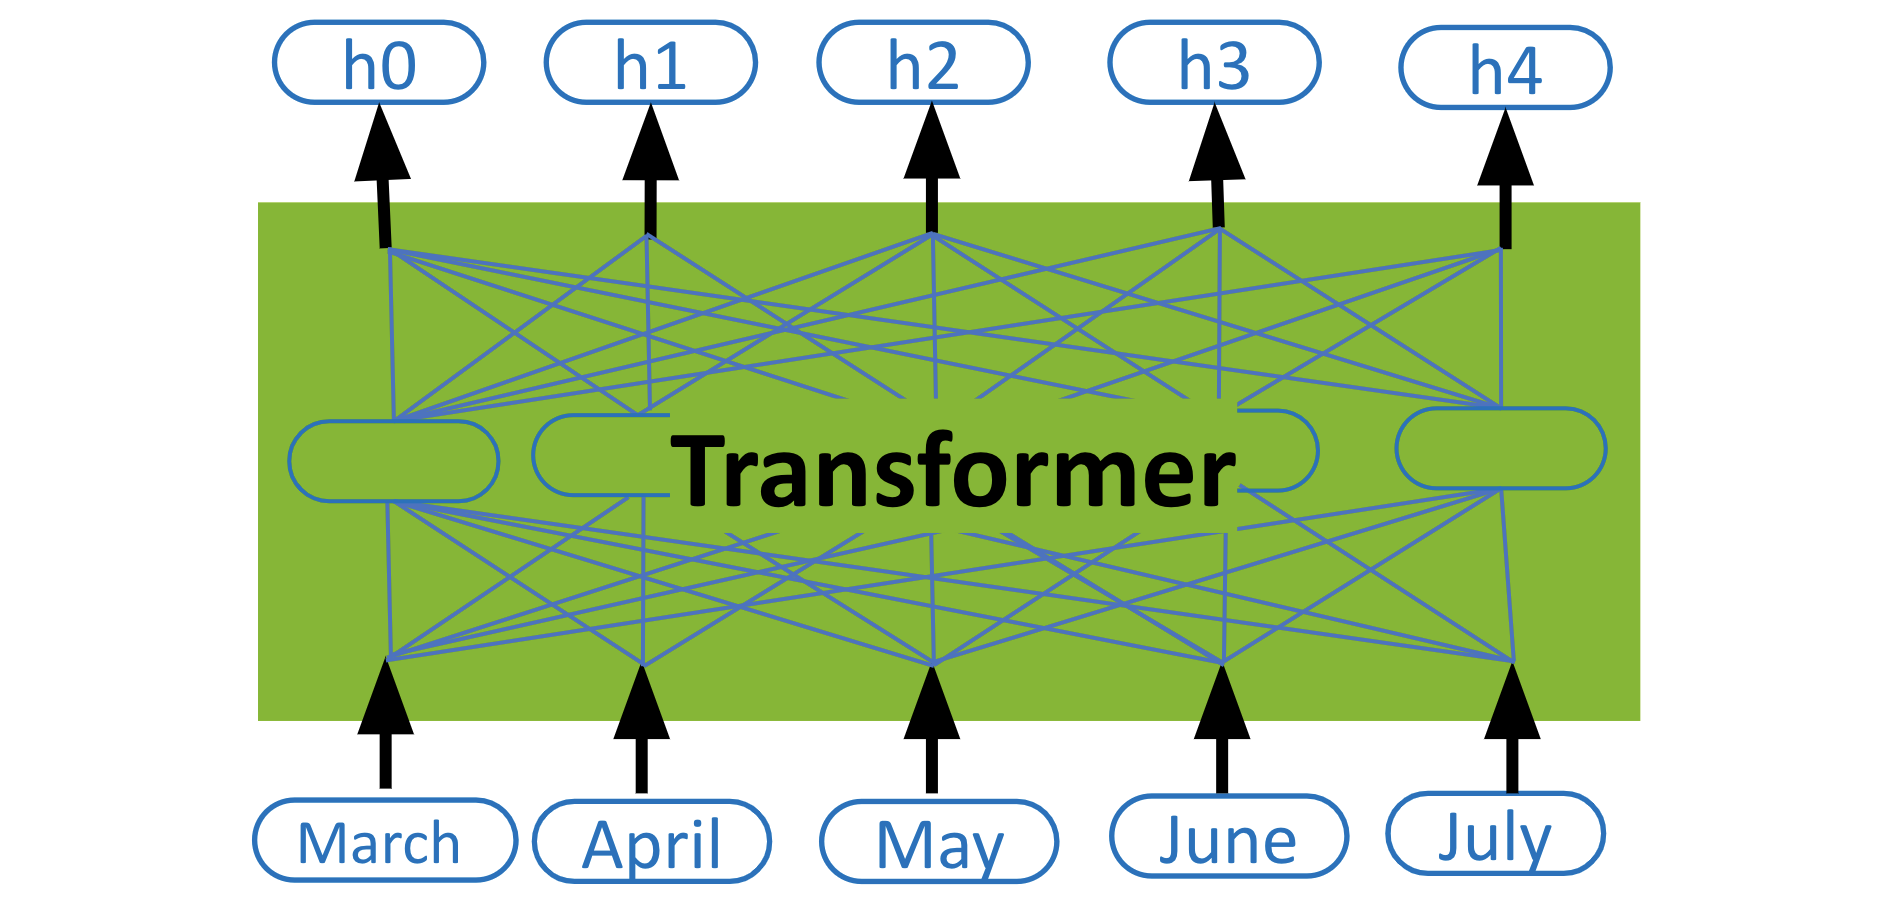

For each customer with less than 13 credit card statements, A padding is added to the data with pad = -1. See example below where the customer has been padded with four -1's:

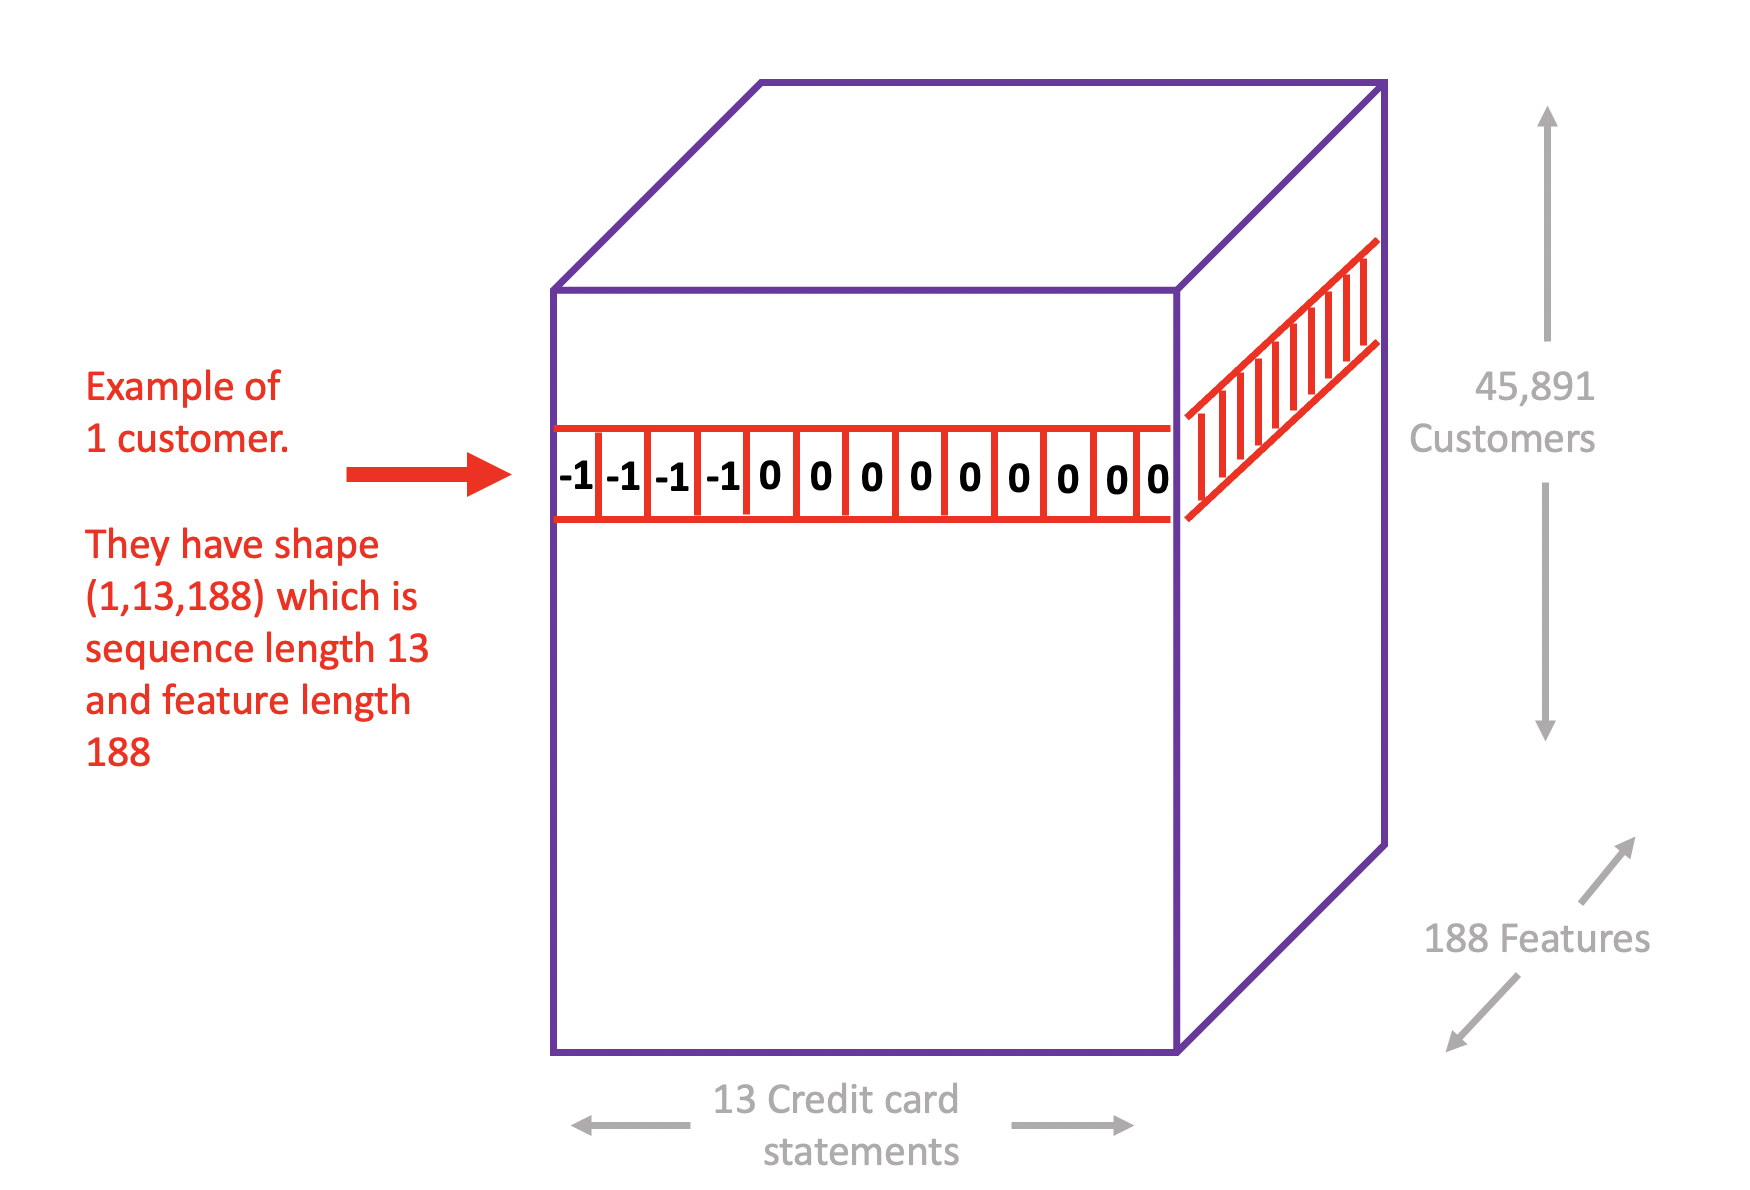

**Define a feature_engineer function as following:**

 - Reduces memory usage of customer_ID column by converting to int64
 - Reduces memory usage of date time column (then deletes the column).
 - Fill NANs
 - Label encodes the categorical columns
 - We reduce memory usage dtypes of columns
 - Converts every customer into a 3D array with sequence length 13 and feature length 188

In [13]:
def feature_engineer(train, PAD_CUSTOMER_TO_13_ROWS = True, targets = None):
  # REDUCE STRING COLUMNS 
  # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
  #print('Processing id column \'customer_ID\'...')
  train['customer_ID'] = train['customer_ID'].apply(lambda x: int(x[-16:],16)).astype('int64')
  #print('Processing datetime column \'S_2\'...')
  train.S_2 = pd.to_datetime( train.S_2 )
  train['year'] = (train.S_2.dt.year-2000).astype('int8')
  train['month'] = (train.S_2.dt.month).astype('int8')
  train['day'] = (train.S_2.dt.day).astype('int8')
  del train['S_2']
        
  # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
  # with 0: padding, 1: nan, 2,3,4,etc: values
  #print('Processing categorical columns...')
  d_63_map = {'CL':2, 'CO':3, 'CR':4, 'XL':5, 'XM':6, 'XZ':7}
  train['D_63'] = train.D_63.map(d_63_map).fillna(1).astype('int8')

  d_64_map = {'-1':2,'O':3, 'R':4, 'U':5}
  train['D_64'] = train.D_64.map(d_64_map).fillna(1).astype('int8')

  CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
  OFFSETS = [2,1,2,2,3,2,3,2,2] #2 minus minimal value in full train csv
  # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
  for c,s in zip(CATS,OFFSETS):
    train[c] = train[c].cat.codes + s
    train[c] = train[c].fillna(1).astype('int8')
  CATS += ['D_63','D_64']
    
  # ADD NEW FEATURES HERE
  # EXAMPLE: train['feature_189'] = etc etc etc
  # EXAMPLE: train['feature_190'] = etc etc etc
  # IF CATEGORICAL, THEN ADD TO CATS WITH: CATS += ['feaure_190'] etc etc etc
    
  # REDUCE MEMORY DTYPE
  SKIP = ['customer_ID','year','month','day']
  for c in train.columns:
    if c in SKIP: continue
    if str( train[c].dtype )=='int64':
      train[c] = train[c].astype('int32')
    if str( train[c].dtype )=='float64':
      train[c] = train[c].astype('float32')
            
    # PAD ROWS SO EACH CUSTOMER HAS 13 ROWS
  
  if PAD_CUSTOMER_TO_13_ROWS:
    tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
    more = np.array([], dtype='int64')
    for j in range(1,13):
      i = tmp.loc[tmp==j].index.values
      more = np.concatenate([more,cupy.repeat(i,13-j)])
    
    df = train.iloc[:len(more)].copy().fillna(0)
    num_cols = df.select_dtypes(include=[object]).columns.tolist()
    df = df * 0 - 1 #pad numerical columns with -1
    df[CATS] = (df[CATS] * 0).astype('int8') #pad categorical columns with 0
    df['customer_ID'] = more
    train = pd.concat([train,df],axis=0,ignore_index=True)
    

  # ADD TARGETS (and reduce to 1 byte)
  if targets is not None:
    del train['target']
    train = train.merge(targets,on='customer_ID', how='left')
    train.target = train.target.astype('int8')
        
  # FILL NAN
  train = train.fillna(-0.5) #this applies to numerical columns
    
  # SORT BY CUSTOMER THEN DATE
  train = train.sort_values(['customer_ID','year','month','day']).reset_index(drop=True)
  train = train.drop(['year','month','day'],axis=1)
    
  # REARRANGE COLUMNS WITH 11 CATS FIRST
  COLS = list(train.columns[1:])
  COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
  train = train[COLS]
    
  return train

### Save processed data into files

The train data has been split into 10 NumPy arrays named `data_1.npy` thru `data_10.npy`. Each array has dimension `(45891, 13, 188)` which is `customer x statement x feature`

In [14]:
if PROCESS_DATA:
  # CREATE PROCESSED TRAIN FILES AND SAVE TO DISK
  start = 0
  end = 0

  for k in range(0, NUM_FILES):
    # READ CHUNK OF TRAIN DATA
    
    start = end
    end = end + rows[k]
    train = train_df.loc[start:end-1].copy()

    # # FEATURE ENGINEER DATAFRAME
    train = feature_engineer(train, targets=targets)

    # # SAVE FILES
    print(f'Train_File_{k+1} has {train.customer_ID.nunique()} customers and shape',train.shape)
    tar = train[['customer_ID','target']].drop_duplicates().sort_index()
    if not os.path.exists(PATH_TO_DATA): os.makedirs(PATH_TO_DATA)
    tar.to_parquet(f'{PATH_TO_DATA}targets_{k+1}.pqt',index=False)
    data = train.iloc[:,1:-1].values.reshape((-1,13,188))
    cupy.save(f'{PATH_TO_DATA}data_{k+1}',data.astype('float32'))

  # CLEAN MEMORY
  del train_df, train, tar, data
  del targets
  gc.collect()

Train_File_1 has 45891 customers and shape (596583, 190)
Train_File_2 has 45891 customers and shape (596583, 190)
Train_File_3 has 45891 customers and shape (596583, 190)
Train_File_4 has 45891 customers and shape (596583, 190)
Train_File_5 has 45891 customers and shape (596583, 190)
Train_File_6 has 45891 customers and shape (596583, 190)
Train_File_7 has 45891 customers and shape (596583, 190)
Train_File_8 has 45891 customers and shape (596583, 190)
Train_File_9 has 45891 customers and shape (596583, 190)
Train_File_10 has 45894 customers and shape (596622, 190)


## Build Transformer Model

### Hyper-parameters

In [15]:
feat_dim = 188
embed_dim = 64  # Embedding size for attention
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.3
num_blocks = 2

### Transformer block

Implement a Transformer block as a layer

In [16]:
class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim),]
    )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

### Build model

Create classifier model using transformer layer

In [17]:
def build_model():
  # INPUT EMBEDDING LAYER
  inp = layers.Input(shape=(13,188))
  embeddings = []
  for k in range(11):
    emb = layers.Embedding(10,4)
    embeddings.append( emb(inp[:,:,k]) )
  x = layers.Concatenate()([inp[:,:,11:]]+embeddings)
  x = layers.Dense(feat_dim)(x)
    
  # TRANSFORMER BLOCKS
  for k in range(num_blocks):
    x_old = x
    transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
    x = transformer_block(x)
    x = 0.9*x + 0.1*x_old # SKIP CONNECTION
    
  # CLASSIFICATION HEAD
  x = layers.Dense(64, activation="relu")(x[:,-1,:])
  x = layers.Dense(32, activation="relu")(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
    
  model = keras.Model(inputs=inp, outputs=outputs)
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  loss = tf.keras.losses.BinaryCrossentropy()
  model.compile(loss=loss, optimizer = opt)
        
  return model

### Learning Schedule

Define a learning rate schedule start from 1e-3 to 1e-06

Learning rate schedule: 0.001 to 0.001 to 1e-06


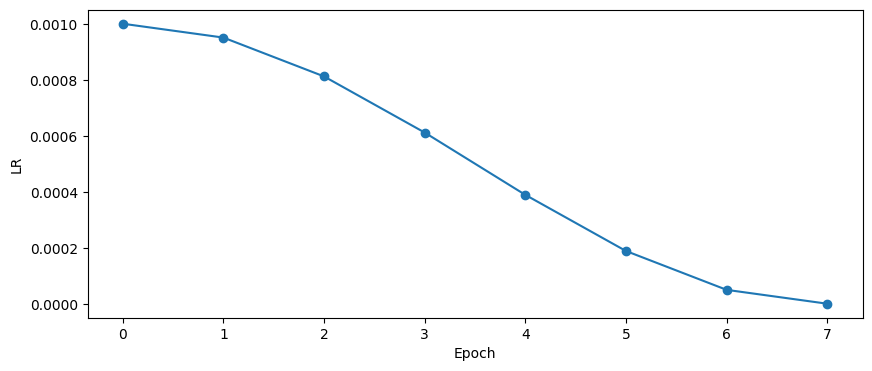

In [18]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 8

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
    decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
    phase = math.pi * decay_epoch_index / decay_total_epochs
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
  return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

## Train Model

We train 5 folds of transformer model with cross validations, 8 epoches for each fold and save the models parameters into `transformer_fold_i.h5` file. For each fold, we calculated the CV score (defined by the Kaggle Competition Metric above)

In [ ]:
if TRAIN_MODEL:
  # SAVE TRUE AND OOF
  true = np.array([])
  oof = np.array([])
  VERBOSE = 2 # use 1 for interactive 

  for fold in range(5):

    # INDICES OF TRAIN AND VALID FOLDS
    valid_idx = [2*fold+1, 2*fold+2]
    train_idx = [x for x in [1,2,3,4,5,6,7,8,9,10] if x not in valid_idx]

    print('#'*25)
    print(f'### Fold {fold+1} with valid files', valid_idx)

    # READ TRAIN DATA FROM DISK
    X_train = []; y_train = []
    for k in train_idx:
      X_train.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
      y_train.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
    X_train = np.concatenate(X_train,axis=0)
    y_train = pd.concat(y_train).target.values
    print('### Training data shapes', X_train.shape, y_train.shape)

    # READ VALID DATA FROM DISK
    X_valid = []; y_valid = []
    for k in valid_idx:
      X_valid.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
      y_valid.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
    X_valid = np.concatenate(X_valid,axis=0)
    y_valid = pd.concat(y_valid).target.values
    print('### Validation data shapes', X_valid.shape, y_valid.shape)
    print('#'*25)

    # BUILD AND TRAIN MODEL
    K.clear_session()
    model = build_model()
    h = model.fit(X_train,y_train, 
            validation_data = (X_valid,y_valid),
            batch_size=512, epochs=EPOCHS, verbose=VERBOSE,
            callbacks = [LR])
    if not os.path.exists(PATH_TO_MODEL): os.makedirs(PATH_TO_MODEL)
    model.save_weights(f'{PATH_TO_MODEL}transformer_fold_{fold+1}.h5')

    # INFER VALID DATA
    print('Inferring validation data...')
    p = model.predict(X_valid, batch_size=512, verbose=VERBOSE).flatten()

    print()
    print(f'Fold {fold+1} CV=', amex_metric_mod(y_valid, p) )
    print()
    true = np.concatenate([true, y_valid])
    oof = np.concatenate([oof, p])
        
    # CLEAN MEMORY
    del model, X_train, y_train, X_valid, y_valid, p
    gc.collect()

  # PRINT OVERALL RESULTS
  print('#'*25)
  print(f'Overall CV =', amex_metric_mod(true, oof) )

#########################
### Fold 1 with valid files [1, 2]
### Training data shapes (367131, 13, 188) (367131,)
### Validation data shapes (91782, 13, 188) (91782,)
#########################


2023-04-12 21:58:13.119745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 21:58:13.121537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 21:58:13.121554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 21:58:13.124287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 21:58:13.124317: I tensorflow/compile


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/8


2023-04-12 21:58:20.448784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


718/718 - 27s - loss: 0.2416 - val_loss: 0.2336 - lr: 0.0010 - 27s/epoch - 37ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009505339495172585.
Epoch 2/8
718/718 - 19s - loss: 0.2306 - val_loss: 0.2311 - lr: 9.5053e-04 - 19s/epoch - 26ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0008119331560284375.
Epoch 3/8
718/718 - 19s - loss: 0.2276 - val_loss: 0.2293 - lr: 8.1193e-04 - 19s/epoch - 26ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0006116492065111791.
Epoch 4/8
718/718 - 19s - loss: 0.2242 - val_loss: 0.2301 - lr: 6.1165e-04 - 19s/epoch - 26ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.00038935079348882104.
Epoch 5/8
718/718 - 19s - loss: 0.2208 - val_loss: 0.2327 - lr: 3.8935e-04 - 19s/epoch - 26ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.00018906684397156263.
Epoch 6/8
718/718 - 19s - loss: 0.2173 - val_loss: 0.2260 - lr: 1.8907e-04 - 19s/epoch - 26ms/step

Epoch 7: Learning

## Process Test Data

The test data is processed the same way as training data which is split in 20 NumPy arrays. Each array has 46231 customers.

The associated targets are contained in the files `targets_1.pqt` thru `targets_10.pqt`. These are parquet files with columns customer_ID and target and have dimension `(45891, 2)`. An example training with these files is here. Note that the `customer_ID` is a `int64` instead of the provided `string512`.

### Load Data

In [6]:
if PROCESS_DATA:
  test_df = pd.read_feather(f'{PATH_TO_DATA}test_data.ftr')
  T_COLS = test_df.columns
  print(f'There are {len(T_COLS)} test dataframe columns')
  test_ids = test_df['customer_ID'].apply(lambda x: int(x[-16:],16)).astype('int64')
  customers = test_ids.drop_duplicates().sort_index().values.flatten()
  print(f'There are {len(customers)} unique customers in test.')
  
  display(test_df.head(2))

There are 190 test dataframe columns
There are 924621 unique customers in test.


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.00146


In [8]:
# split training data into 10 files
NUM_FILES = 20
if PROCESS_DATA:
  rows = get_rows(customers, test_ids, NUM_FILES = NUM_FILES, verbose = 'test')

We will split test data into 20 separate files.
There will be 46231 customers in each file (except the last file).
Below are number of rows in each file:
[567933, 568482, 569369, 567886, 567539, 568041, 568138, 567596, 568543, 567539, 568421, 568745, 568279, 568333, 568327, 568901, 568300, 568001, 567372, 568017]


### Save processed data into files

The test data has been split into 20 NumPy arrays named `test_data_1.npy` thru `test_data_1.npy`. Each array has dimension `(46231, 13, 188)` which is `customer x statement x feature`

In [13]:
if PROCESS_DATA:
  # SAVE TEST CUSTOMERS INDEX
  test_customer_hashes = np.array([],dtype='int64')

  start = 0
  end = 0

  # CREATE PROCESSED TEST FILES AND SAVE TO DISK
  for k in range(0, NUM_FILES):
    # READ CHUNK OF TEST DATA

    start = end
    end = end + rows[k]
    test = test_df.loc[start:end-1].copy()

    # # FEATURE ENGINEER DATAFRAME
    test = feature_engineer(test, targets=None)

    # SAVE TEST CUSTOMERS INDEX
    cust = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
    test_customer_hashes = np.concatenate([test_customer_hashes,cust])

    # # SAVE FILES
    print(f'Test_File_{k+1} has {test.customer_ID.nunique()} customers and shape',test.shape)
    if not os.path.exists(PATH_TO_DATA): os.makedirs(PATH_TO_DATA)
    data = test.iloc[:,1:].values.reshape((-1,13,188))
    cupy.save(f'{PATH_TO_DATA}test_data_{k+1}',data.astype('float32'))

  # SAVE CUSTOMER INDEX OF ALL TEST FILES
  cupy.save(f'{PATH_TO_DATA}test_hashes_data', test_customer_hashes)

  # CLEAN MEMORY
  del test_df, test, data
  gc.collect()

Test_File_1 has 46231 customers and shape (601003, 189)
Test_File_2 has 46231 customers and shape (601003, 189)
Test_File_3 has 46231 customers and shape (601003, 189)
Test_File_4 has 46231 customers and shape (601003, 189)
Test_File_5 has 46231 customers and shape (601003, 189)
Test_File_6 has 46231 customers and shape (601003, 189)
Test_File_7 has 46231 customers and shape (601003, 189)
Test_File_8 has 46231 customers and shape (601003, 189)
Test_File_9 has 46231 customers and shape (601003, 189)
Test_File_10 has 46231 customers and shape (601003, 189)
Test_File_11 has 46231 customers and shape (601003, 189)
Test_File_12 has 46231 customers and shape (601003, 189)
Test_File_13 has 46231 customers and shape (601003, 189)
Test_File_14 has 46231 customers and shape (601003, 189)
Test_File_15 has 46231 customers and shape (601003, 189)
Test_File_16 has 46231 customers and shape (601003, 189)
Test_File_17 has 46231 customers and shape (601003, 189)
Test_File_18 has 46231 customers and sha

## Infer Test Data

The test data is loaded and rehashed based on our `test_hashes_data.npy`, then we apply the transformer models (5 folds) created above to predict the target. We use ensemble method to average the predictions divided by 5 for each transformer model.

In [25]:
if INFER_TEST:
  # BUILD MODEL
  K.clear_session()
  model = build_model()
    
  # LOAD SAMPLE SUBMISSION
  start = 0; end = 0
  sub = pd.read_csv(f'{PATH_TO_SUBMISSIONS}sample_submission.csv')
  
  # REARANGE SUB ROWS TO MATCH 20 TEST FILES
  sub['hash'] = sub['customer_ID'].apply(lambda x: int(x[-16:],16)).astype('int64')
  test_hash_index = cupy.load(f'{PATH_TO_DATA}test_hashes_data.npy')
  sub = sub.set_index('hash').loc[test_hash_index.get()].reset_index(drop=True)
    
  for k in range(20):
    print(f'Inferring Test_File_{k+1}')
    X_test = np.load(f'{PATH_TO_DATA}test_data_{k+1}.npy')
    end = start + X_test.shape[0]

    # INFER 5 FOLD MODELS
    model.load_weights(f'{PATH_TO_MODEL}transformer_fold_1.h5')
    p = model.predict(X_test, batch_size=512, verbose=0).flatten() 
    for j in range(1,5):
      model.load_weights(f'{PATH_TO_MODEL}transformer_fold_{j+1}.h5')
      p += model.predict(X_test, batch_size=512, verbose=0).flatten()
    p /= 5.0

    sub.loc[start:end-1,'prediction'] = p
    start = end

    del X_test
    gc.collect()

Inferring Test_File_1
Inferring Test_File_2
Inferring Test_File_3
Inferring Test_File_4
Inferring Test_File_5
Inferring Test_File_6
Inferring Test_File_7
Inferring Test_File_8
Inferring Test_File_9
Inferring Test_File_10
Inferring Test_File_11
Inferring Test_File_12
Inferring Test_File_13
Inferring Test_File_14
Inferring Test_File_15
Inferring Test_File_16
Inferring Test_File_17
Inferring Test_File_18
Inferring Test_File_19
Inferring Test_File_20


## Create Kaggle Submission

In [26]:
if INFER_TEST:
  sub.to_csv(f'{PATH_TO_SUBMISSIONS}submission.csv',index=False)
  print('Submission file shape is', sub.shape )
  display( sub.head() )

Submission file shape is (924621, 2)


,customer_ID,prediction
0,038be0571bd6b3776cb8512731968f4de302c811030124...,0.001313
1,0074a0233ef766b52884608cc8cf9098f59d885b5d59fc...,0.000208
2,060b8b7f30f795a0e93995d45b29461ffa6ece0eeb5c3d...,0.096246
3,03a1d125bdd776000bf0b28238d0bea240ad581d332e70...,0.092442
4,0290f245dd35ba899af52316ccc62b2627e7ae18cd76a2...,0.360643


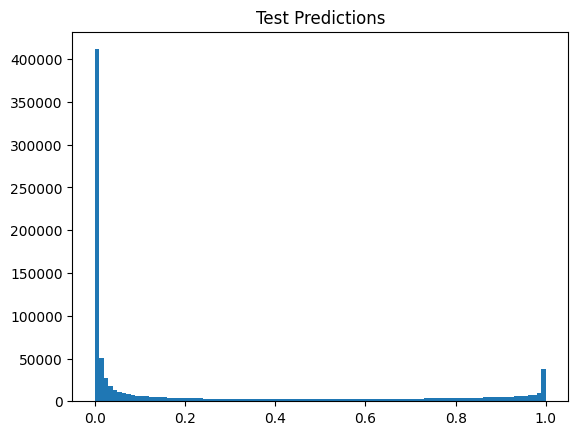

In [28]:
if INFER_TEST:
  # DISPLAY SUBMISSION PREDICTIONS
  plt.hist(sub.prediction, bins=100)
  plt.title('Test Predictions')
  plt.show()

## Performance

We got 0.79831 for private score and 0.78911 for public score

**Kaggle submission**

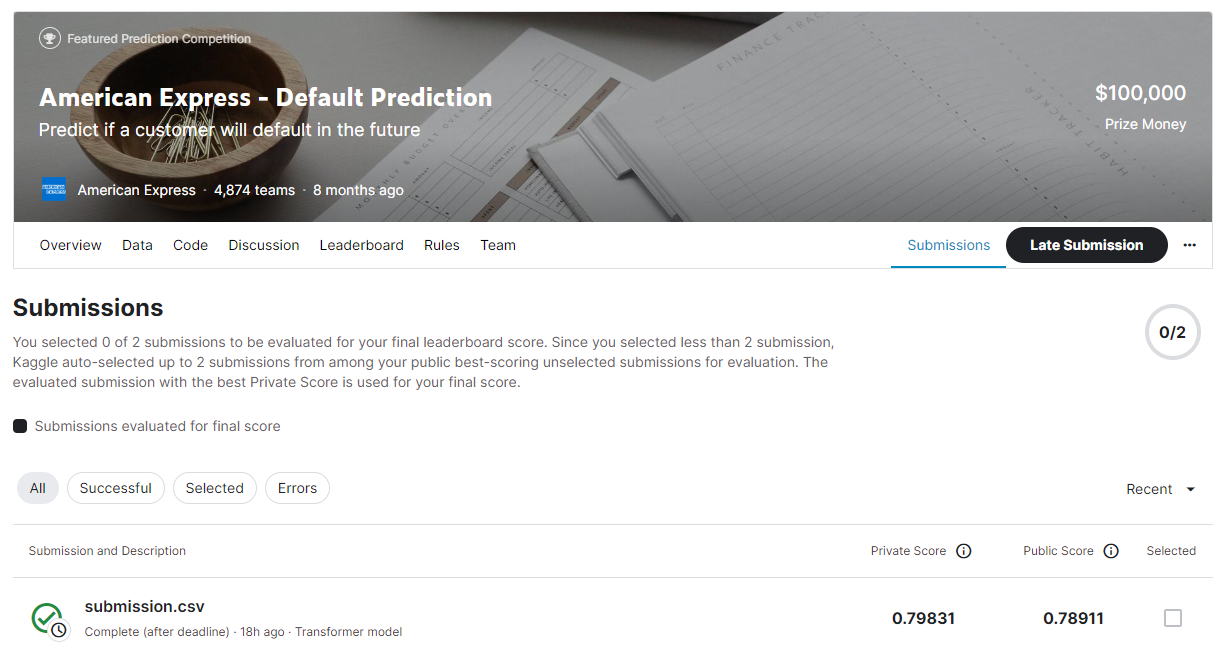

**Kaggle leaderboard** (for reference)

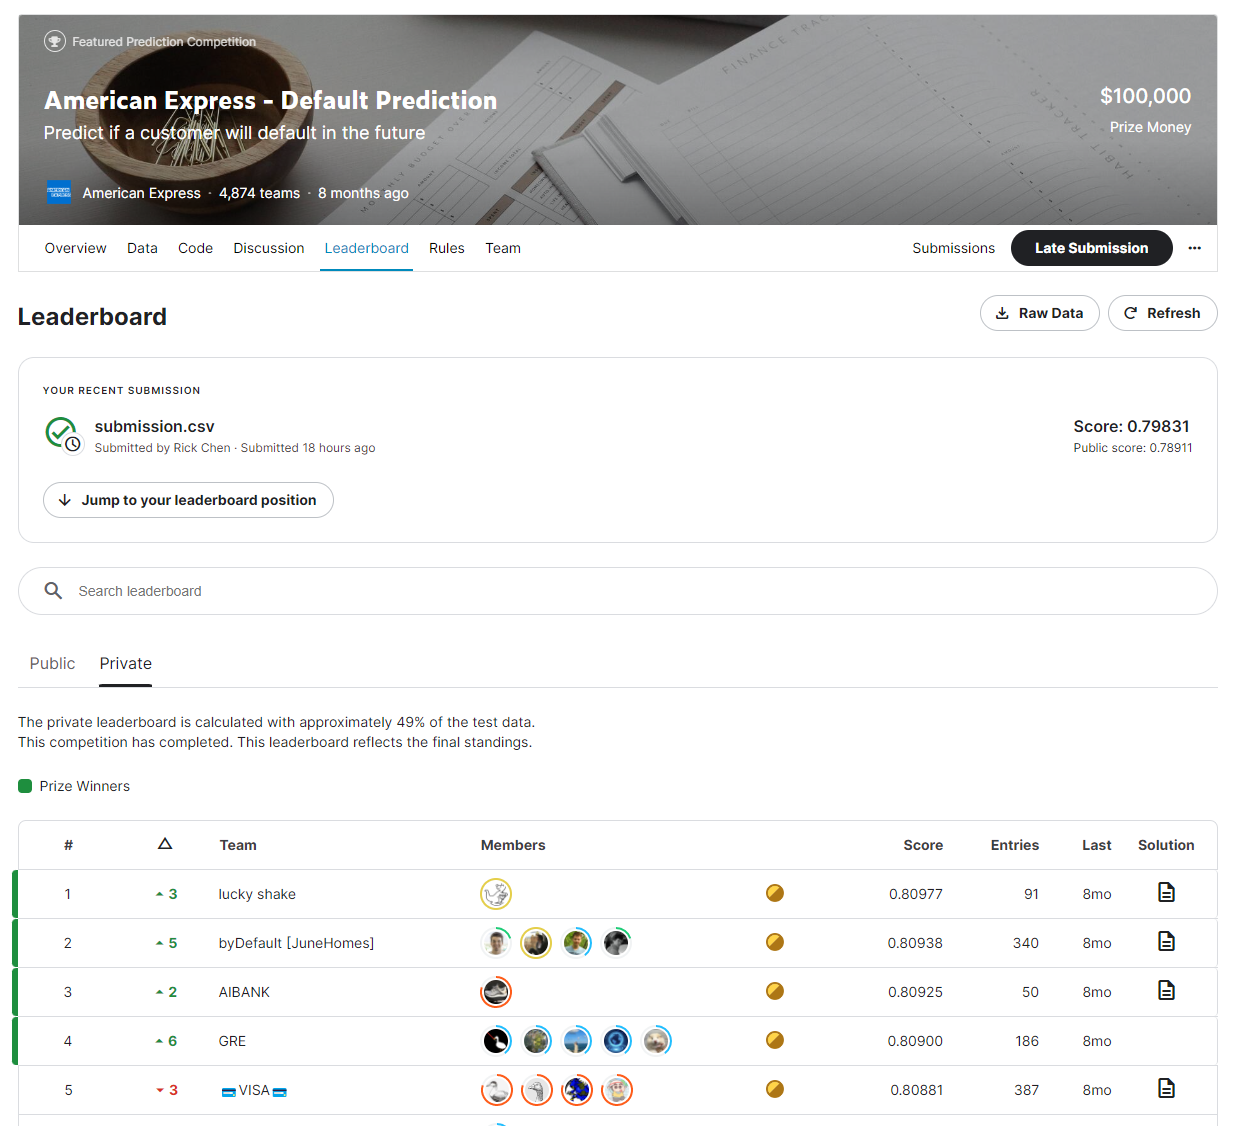